In [66]:
import shap
import pickle
import matplotlib.pyplot as plt

import numpy as np

In [9]:
with open("./data/model_xgb.pickle", "rb") as model_file:
    model_xgb = pickle.load(model_file)

In [18]:
with open("./data/dataset.pickle", "rb") as dataset_file:
    X = pickle.load(dataset_file)

In [63]:
colors = ["brown", "teal", "blue", "coral", "limegreen"]

In [60]:
def create_variable_list(col):
    min_val = col.min()
    max_val = col.max()

    unique = col.unique()

    if len(unique) < 50:
        col_vals = sorted(list(unique))
    else:
        delta = (max_val - min_val) / 100
        col_vals = []
        while min_val <= max_val:
            col_vals.append(min_val)
            min_val += delta
    return col_vals

In [61]:
def top5_find_by_importance(explainer, data):
    shap_values = explainer(data).values

    col_names = []
    indexes = []
    mean_importance = list(np.mean(np.absolute(shap_values), axis=0))

    max_list = sorted(mean_importance)[-5:]
    for max_val in max_list:
        indexes.append(mean_importance.index(max_val))
        col_names.append(data.columns[mean_importance.index(max_val)])

    return col_names, indexes

In [62]:
def top5_centered_importance(explainer, data, col_name):
    data_copy = data.copy()

    col_vals = create_variable_list(data[col_name])
    res_vals = []

    for val in col_vals:
        new_col = len(data_copy[col_name]) * [val]
        data_copy[col_name] = new_col
        shap_values = explainer(data_copy).values
        res_vals.append(shap_values)

    return res_vals, col_vals

In [64]:
def plot_top5_centered_importance(model, data, col_name, absolute=False):
    plot = plt.axes()
    plot.figure.set_size_inches(16, 8)

    if absolute:
        title = "Центрированный график изменения абсолютной важности переменных"
    else:
        title = "Центрированный график изменения важности переменных"
    plot.set_title(title, fontsize=18)

    explainer = shap.TreeExplainer(model)

    data_copy = data.copy()
    if "y" in data.columns:
        data_copy = data_copy.drop("y", axis=1)

    cols, indexes = top5_find_by_importance(explainer, data_copy)

    res_vals, col_vals = top5_centered_importance(explainer, data_copy, col_name)

    res_vals = np.array(res_vals)

    for i in range(0, len(indexes)):
        res = []

        for j in range(0, len(res_vals)):
            val = res_vals[j, :, indexes[i]]
            if absolute:
                val = np.absolute(val)
            res.append(val.mean())

        plot.plot(col_vals, res, color=colors[i], linewidth=4, label=cols[i])

    plot.grid()
    plot.set_xlabel(col_name, fontsize=16)
    plot.set_ylabel("Важность переменных", fontsize=16)
    plot.legend()

    return plot

<Axes: title={'center': 'Центрированный график изменения важности переменных'}, xlabel='Age', ylabel='Важность переменных'>

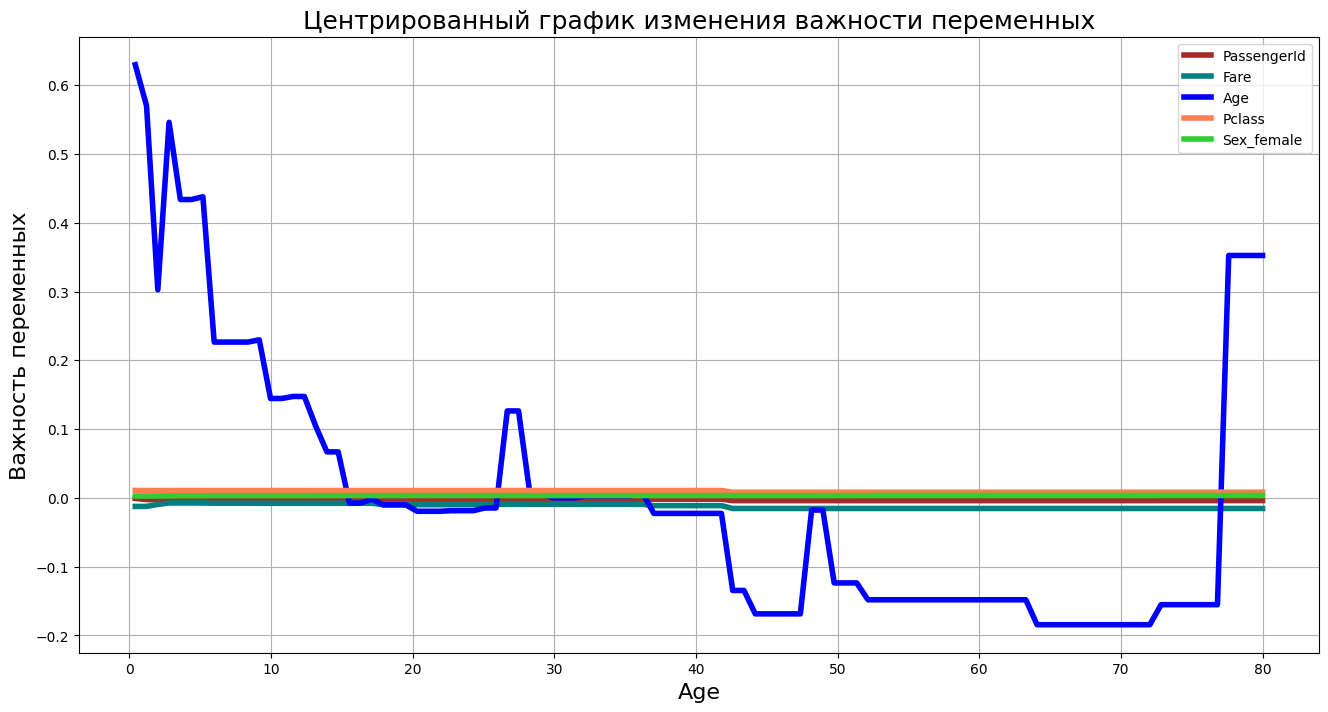

In [67]:
plot_top5_centered_importance(model_xgb, X, "Age")